In [1]:
import numpy as np
import matplotlib.pyplot as plt

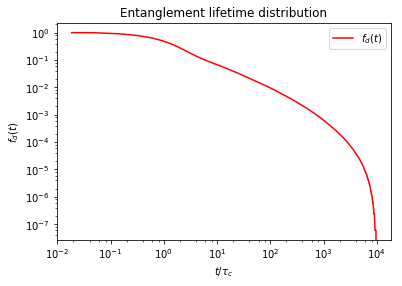

In [26]:
with open('fdt.dat') as f:
    lines = f.readlines()
    x = [line.split()[0] for line in lines]
    y = [line.split()[1] for line in lines]

fig = plt.figure()

ax1 = fig.add_subplot(111)

ax1.set_title("Entanglement lifetime distribution")    
ax1.set_xlabel(r'$t/\tau_c$')
ax1.set_ylabel(r'$f_d(t)$')

ax1.plot(x,y, c='r', label=r'$f_d(t)$')

leg = ax1.legend()
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.show()